# qsm-chicago_model_A.ipynb
Author: Connacher Murphy

## 0. Libraries

In [359]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## 1. Calibration
We create the commuting flows matrix $\mathbf{\pi}$, where $\pi_{i n}$ denotes the share of workers living in neighborhood $i$ commuting to neighborhood $n$.

In [360]:
# Read commuting flows from csv
flows_pd = pd.read_csv('../data/chi_flows_nbhd_matrix.csv')

# Convert to numpy array
flows = flows_pd.values[:, 1:]

K = flows.shape[0] # number of neighborhoods

# Calculate population by workplace and residence
H = np.sum(flows, axis = 1, keepdims=True) # residence
L = np.sum(flows, axis = 0, keepdims=True) # workplace

# Normalize by residential population to get conditional commuting probabilities
pi = flows / H

In [361]:
# Identify neighborhood clusters
neighborhoods_pd = pd.read_csv('../data/id_nbhd.csv')

far_southeast_indices = neighborhoods_pd[
    neighborhoods_pd['far_southeast'] == 1
]['id'].values - 1

employment_core_indices = neighborhoods_pd[
    neighborhoods_pd['employment_core'] == 1
]['id'].values - 1

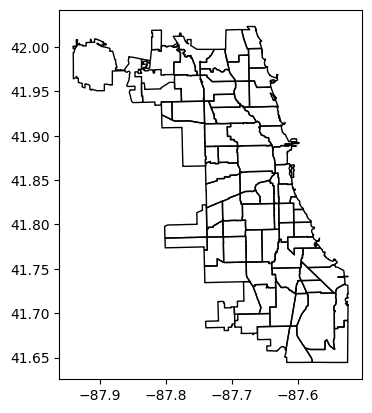

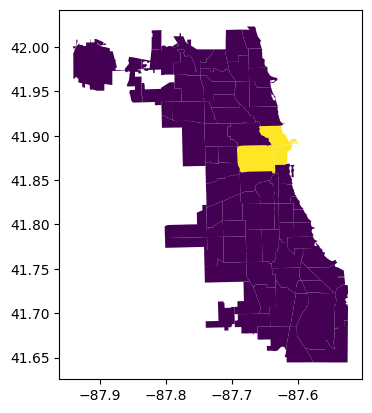

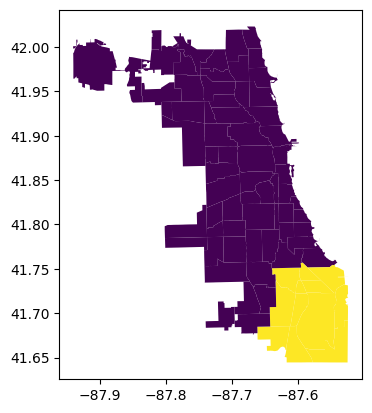

In [362]:
# Import Chicago neighborhoods shapefile
neighborhoods_shp = gpd.read_file('../data/neighborhoods').merge(
    neighborhoods_pd, on='community'
)

# Plot neighborhood boundaries
neighborhoods_shp.plot(facecolor='none', edgecolor='black')
plt.show()

neighborhoods_shp.plot(column='employment_core')
plt.show()

neighborhoods_shp.plot(column='far_southeast')
plt.show()

In [363]:
theta = 3.0
alpha = 0.6

## 2. Counterfactual solver
Following the notation in the writeup, I let $i$ correspond to the first index and $n$ to the second.

In [364]:
# Define component functions for counterfactual solver
def calc_real_wage_hat(w_hat, kappa_hat):
    """
    Calculate changes in real wages
    Arguments:
        w_hat: wage changes
        kappa_hat: shock to kappa
    """
    return w_hat / kappa_hat


def calc_real_wage_hat_scale(theta, real_wage_hat):
    """
    Scale the changes in real wages by theta
    Arguments:
        real_wage_hat: changes in real wages
        theta: preference shock dispersion parameter
    """
    return np.power(
        real_wage_hat,
        theta
    )


def calc_Phi_hat(pi_init, real_wage_hat_scale):
    """
    Calculate Phi_hat
    Arguments:
        pi_init: commuting probabilities
        real_wage_hat_scale: changes in real wages
    """
    return np.sum(
        pi_init * real_wage_hat_scale,
        axis=1,
        keepdims=True
    )


def calc_pi_hat(theta, pi_init, w_hat, kappa_hat):
    """
    Calculate pi_hat
    Arguments:
        theta: preference shock dispersion parameter
        pi_init: commuting probabilities
        w_hat: changes in wages
        kappa_hat: shock to kappa
    """
    real_wage_hat = calc_real_wage_hat(w_hat, kappa_hat)
    real_wage_hat_scale = calc_real_wage_hat_scale(theta, real_wage_hat)
    Phi_hat = calc_Phi_hat(pi_init, real_wage_hat_scale)

    return real_wage_hat_scale / Phi_hat


def calc_Z(
        w_tilde, theta, alpha, pi_init, H_init, L_init, A_hat, kappa_hat, H_hat
):
    """
    Calculate calligraphic Z for candidate wage changes
    Arguments:
        w_tilde: candidate wage changes

        theta: preference shock dispersion parameter
        alpha: elasticity of output with respect to labor
        pi_init: initial commuting probabilities
        H_init: initial residential population
        L_init: initial workplace population

        A_hat: shock to A
        kappa_hat: shock to kappa
        H_hat: shock to residential population
    """

    demand_term = np.power(
        A_hat / w_tilde,
        1 / (1 - alpha)
    )

    pi_hat = calc_pi_hat(theta, pi_init, w_tilde, kappa_hat)

    supply_term = np.sum(
        pi_init * H_init * pi_hat * H_hat,
        axis=0,
        keepdims=True
    ) / L_init

    return(demand_term - supply_term)

In [365]:
# Unit test
# calc_Z should return all zeros if we guess the correct wage changes
# We can set all parameter proportional changes to 1 (no changes) and check
# that a vector of unchanged wages is an equilibrium
w_tilde = np.ones((1, K)) # use the second index to follow tilde(w)_n notation
A_hat = np.ones((1, K))
H_hat = np.ones((K, 1))
kappa_hat = np.ones((K, K))
H_hat = np.ones((K, 1))

print(
    calc_Z(w_tilde, theta, alpha, pi, H, L, A_hat, kappa_hat, H_hat)
)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]


In [366]:
def solve_counterfactual(
        theta, alpha, pi_init, H_init, L_init, A_hat, kappa_hat, H_hat
):
    w_tilde = np.ones((1, K)) # initial guess for wage changes
    i = 0 # iteration counter
    error = 1.0 # initialize error
    tol = 1e-10 # error tolerance
    kappa = 0.1 # step size

    while error > tol: # iterate until error is below tolerance
        Z = calc_Z(
            w_tilde, theta, alpha, pi_init, H_init, L_init, A_hat, kappa_hat, H_hat
        )

        w_tilde = w_tilde + (Z * kappa) # update wage

        error = np.absolute(Z).max() # calculate error
        print("Step", i, "error:", round(error, 10))
        i += 1
    
    return w_tilde

In [367]:
# Run the unit test again, using the solve_counterfactual() function
w_hat = solve_counterfactual(theta, alpha, pi, H, L, A_hat, kappa_hat, H_hat)
print(w_hat)

Step 0 error: 0.0
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1.]]


In [368]:
def summarize_counterfactual(neighborhoods_shp, w_hat, A_hat):
    df_hat = pd.DataFrame( # stack wage and productivity changes into df
        np.column_stack((
            w_hat.reshape((K)), A_hat.reshape((K))
        )),
        columns=['w_hat', 'A_hat']
    )

    df_hat['id'] = df_hat.index + 1

    df_hat_shp = neighborhoods_shp.merge( # merge with shapefile
        df_hat, on='id'
    )

    return df_hat_shp

## 3. Counterfactual exercises

### 3.i. Local productivity shock

In [369]:
print('Local productivity shock in far southeast')

A_hat[:,far_southeast_indices] = 1.05 # increase productivity by 5% in far southeast
w_hat = solve_counterfactual(theta, alpha, pi, H, L, A_hat, kappa_hat, H_hat)

productivity_shock_shp = summarize_counterfactual(neighborhoods_shp, w_hat, A_hat)

Local productivity shock in far southeast
Step 0 error: 0.1297263219
Step 1 error: 0.0603006826
Step 2 error: 0.0285251139
Step 3 error: 0.0136829422
Step 4 error: 0.0066695423
Step 5 error: 0.0033224206
Step 6 error: 0.0017055958
Step 7 error: 0.0009111593
Step 8 error: 0.0005111351
Step 9 error: 0.0003027803
Step 10 error: 0.000189409
Step 11 error: 0.0001244453
Step 12 error: 8.51049e-05
Step 13 error: 5.99853e-05
Step 14 error: 4.31953e-05
Step 15 error: 3.15603e-05
Step 16 error: 2.32813e-05
Step 17 error: 1.73058e-05
Step 18 error: 1.29525e-05
Step 19 error: 9.702e-06
Step 20 error: 7.2711e-06
Step 21 error: 5.4512e-06
Step 22 error: 4.0878e-06
Step 23 error: 3.0658e-06
Step 24 error: 2.2996e-06
Step 25 error: 1.725e-06
Step 26 error: 1.2941e-06
Step 27 error: 9.708e-07
Step 28 error: 7.283e-07
Step 29 error: 5.464e-07
Step 30 error: 4.099e-07
Step 31 error: 3.075e-07
Step 32 error: 2.307e-07
Step 33 error: 1.731e-07
Step 34 error: 1.299e-07
Step 35 error: 9.74e-08
Step 36 error:

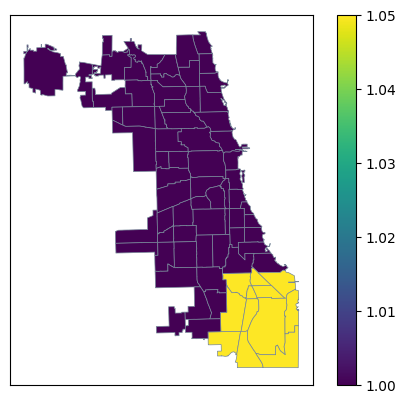

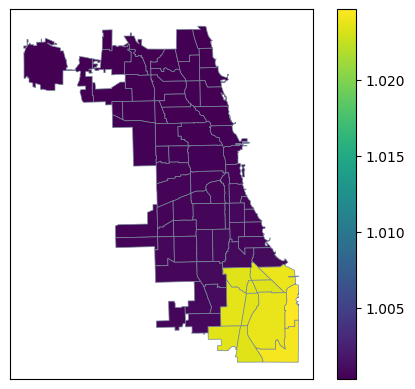

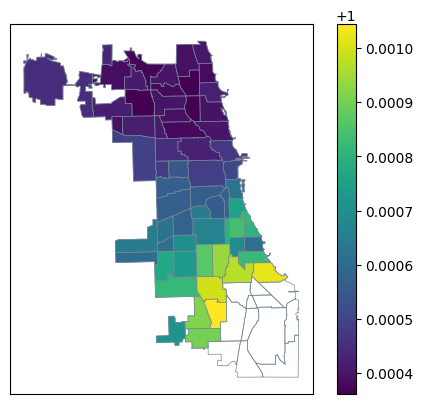

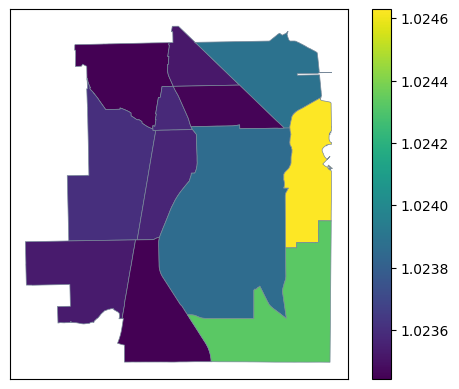

In [370]:
# Summarize results
figsize = (10, 10)

# A_hat
productivity_shock_shp.plot(
    column='A_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
# plt.title('$\\hat{A}$')
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_A_hat.png')
plt.show()

# w_hat (all neighborhoods)
productivity_shock_shp.plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat.png')
plt.show()

# w_hat (exclude far southeast)
fig, ax = plt.subplots()

# Full boundaries
productivity_shock_shp.plot(
    facecolor='none', edgecolor='lightslategray', linewidth=0.5, ax=ax
)
# Exclude far southeast
productivity_shock_shp[productivity_shock_shp['far_southeast'] == 0].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5, ax=ax
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat_censor.png')
plt.show()

# w_hat (only far southeast)
productivity_shock_shp[productivity_shock_shp['far_southeast'] == 1].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat_focus.png')
plt.show()